# Week 5 Practicum

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

### Jsonl Cleaning and Jsonl -> Dataframe -> CSV

In this code I created a method which utalizes the jsonl file cade pulled from pushshift and basically goes through all the different values and pulls out the necessary values we'll be using within our model and some other necessary information for data exploration

In [2]:
def parse_jsonl_file(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            try:
                entry = json.loads(line.strip())
                title = entry.get('title')
                selftext = entry.get('selftext')
                link_flair_text = entry.get('link_flair_text')
                post_id = entry.get('id')
                url = entry.get('url')
                num_comments = entry.get('num_comments')
                score = entry.get('score')

                if link_flair_text == 'None':
                    continue
                
                data.append({
                    'title': title,
                    'selftext': selftext,
                    'link_flair_text': link_flair_text,
                    'id': post_id,
                    'url': url,
                    'num_comments': num_comments,
                    'score': score
                    
                })
            except json.JSONDecodeError:
                print("Error decoding JSON line:", line)
    return data

file_path = 'r_udub_posts.jsonl'
parsed_data = parse_jsonl_file(file_path)

df_jsonl = pd.DataFrame(parsed_data)

df_jsonl.head(5)

This Part of the code moves the now created dataframe and transforms it into a CSV so it's easier to handle and allows for us to all work with the same Data Set

In [3]:
csv_file_path = 'r_udub_posts.csv'
df_jsonl.to_csv(csv_file_path, index=False)
print("DataFrame saved as CSV:", csv_file_path) 

,title,selftext,link_flair_text,id,url,num_comments,score
0,Any UW redditors want to meet up Thursday 10/2...,"We failed on 10/22, but I think with a week of...",NaN,9y4hg,https://www.reddit.com/r/udub/comments/9y4hg/a...,6,4
1,We need a UW-ified logo.,If someone here has arcane skill in the graphi...,NaN,9ywtc,https://www.reddit.com/r/udub/comments/9ywtc/w...,2,3
2,Thursday bowling success!,[deleted],NaN,9z66c,https://www.reddit.com/r/udub/comments/9z66c/t...,2,3
3,"Next UW meetup: Thursday, 11/5 at 11:00am in t...",This time we will be playing ping pong followe...,NaN,a0ail,https://www.reddit.com/r/udub/comments/a0ail/n...,2,4
4,Next meetup: December 3rd. Need ideas,"Alright, so who is up for a December 3rd meetu...",NaN,a9lq8,https://www.reddit.com/r/udub/comments/a9lq8/n...,7,2


In [ ]:
posts = pd.read_csv('r_udub_posts.csv')
posts.head(5)

,title,selftext,link_flair_text,id,url,num_comments,score
0,Any UW redditors want to meet up Thursday 10/2...,"We failed on 10/22, but I think with a week of...",NaN,9y4hg,https://www.reddit.com/r/udub/comments/9y4hg/a...,6,4
1,We need a UW-ified logo.,If someone here has arcane skill in the graphi...,NaN,9ywtc,https://www.reddit.com/r/udub/comments/9ywtc/w...,2,3
2,Thursday bowling success!,[deleted],NaN,9z66c,https://www.reddit.com/r/udub/comments/9z66c/t...,2,3
3,"Next UW meetup: Thursday, 11/5 at 11:00am in t...",This time we will be playing ping pong followe...,NaN,a0ail,https://www.reddit.com/r/udub/comments/a0ail/n...,2,4
4,Next meetup: December 3rd. Need ideas,"Alright, so who is up for a December 3rd meetu...",NaN,a9lq8,https://www.reddit.com/r/udub/comments/a9lq8/n...,7,2


In [ ]:
posts['link_flair_text'].unique()

array([nan, 'PSA', 'Rant', 'Random', 'Meme', 'Question', 'Discussion',
       'Academics', 'Student Life', 'Help', 'Event', 'Video',
       'Admissions', 'Advice', 'Poll', 'poll', 'No unrelated posts'],
      dtype=object)

This next code is pretty much our main filter to bring our data from raw data into data which we can be fed into a model. In this case we combined the title and body text into one column so we can have more text tokenizer and utalize.Alongside this we also got rid of any posts which had not body, no flair or if the post is removed/deleted. Finally we removed any flairs not currently in use then lowercased them all to combine redundant flairs. 

In [ ]:
posts['combined_text'] = posts['title'] + " " + posts['selftext'].fillna("")
flair_categories = ["admissions", "academics", "student life", "advice", "discussion", "meme", "rant", "psa", "event", "poll"]

flairedNotSelf = posts[(posts['link_flair_text'].notnull()) & (posts['selftext'] != '[removed]') & (posts['selftext'] != '[deleted]') & posts['selftext'].notnull()]
ModelDataLower = flairedNotSelf.apply(lambda col: col.str.lower() if col.dtype == 'object' else col)
ModelDataFiltered = ModelDataLower[ModelDataLower['link_flair_text'].isin(flair_categories)][['combined_text', 'link_flair_text']]

ModelDataFiltered.head()

,combined_text,link_flair_text
28066,thoughts on madrona? i have an emotional suppo...,discussion
28077,soc 222 anyone has took or taking soc222(socio...,academics
28080,betsy evans - ling/anth 233 does anyone have a...,academics
28083,tell me what you want from remote teaching? th...,discussion
28088,efs experience/thoughts/opinions! i just regis...,discussion


### Question:
* Can machine learning models effectively predict these flairs based on post content?
### Hypothesis:
* Posts' textual content can be used to predict flairs with reasonable accuracy, reflecting underlying patterns that distinguish different types of discussions on Reddit.
### Context and Motivation:
* Flair categorization helps in organizing content and improving user experience on Reddit. Automated flair prediction can assist moderators and enhance content discoverability.
### Definitions and Data:
* Flair: A label applied by users or moderators to categorize posts.
* Data: A dataset of Reddit posts from r/udub, including titles, bodies of text, and user-assigned flairs coming from Articshift, built upon Pushift.
### Methods:
* Text processing with TF-IDF vectorization to transform text data into a suitable format for machine learning.
* Clustering (K-Means) to identify inherent groupings and patterns in the data.
* Classification models including Logistic Regression and Support Vector Machines (SVM) to predict post flairs.
### Assumption:
* Assumes that the text of a post is indicative of the flair; ignores other metadata like time of posting or user engagement metrics.
### Bias:
* Potential bias in data due to self-selected flairs which may not accurately represent the content.

In [ ]:
def clean_tokenize(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    return tokens

ModelDataFiltered['tokens'] = ModelDataFiltered['combined_text'].apply(clean_tokenize)

In [ ]:
tfidf = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, max_features=5000)
texts_tfidf = tfidf.fit_transform(ModelDataFiltered['tokens'])

kmeans = KMeans(n_clusters=11, random_state=0)
ModelDataFiltered['cluster'] = kmeans.fit_predict(texts_tfidf)

cluster_centers = kmeans.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


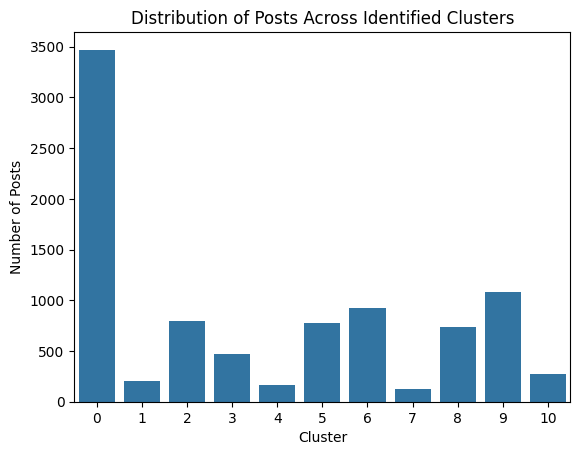

In [ ]:
sns.countplot(x='cluster', data=ModelDataFiltered)
plt.title('Distribution of Posts Across Identified Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Posts')
plt.show()

A Simple print out of how many posts are in each of the clusters

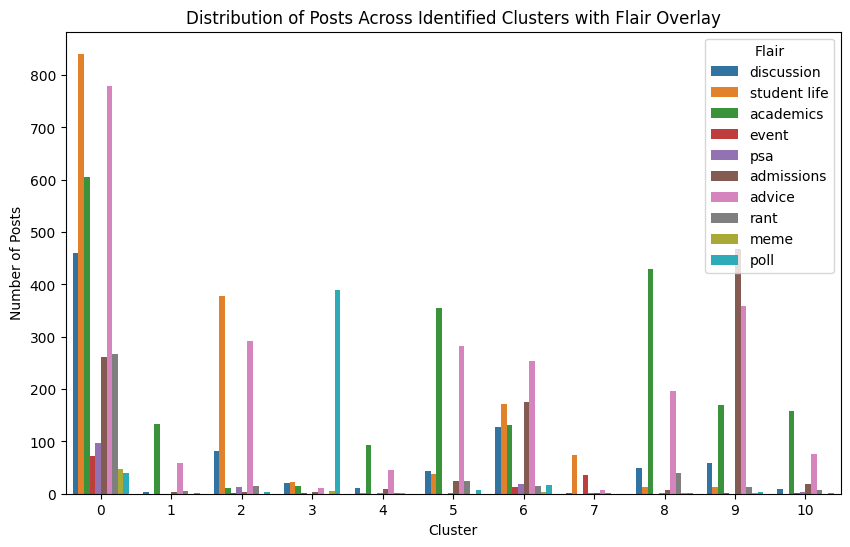

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=ModelDataFiltered, x='cluster', hue='link_flair_text')
plt.title('Distribution of Posts Across Identified Clusters with Flair Overlay')
plt.xlabel('Cluster')
plt.ylabel('Number of Posts')
plt.legend(title='Flair', loc='upper right')
plt.show()

Detailed view on each of the clusters, seeing how many flairs and their posts were put in these clusters. Here what we can see is that Cluster 0 and 2 was able to find a lot of "student life" and "advice" flairs. But a interesting pattern we can see here is that "advice" flair tends to be similar to a lot of other posts like "student life", "academics", and "admissions". This makes sense as advice is such a broad thing and any of the 3 flairs can technically be on advice (Maybe suggesting that ability to put multiple flairs could be nice).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    texts_tfidf, ModelDataFiltered['link_flair_text'], test_size=0.2, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

   academics       0.63      0.69      0.66       436
  admissions       0.72      0.64      0.68       195
      advice       0.46      0.53      0.49       468
  discussion       0.27      0.10      0.15       161
       event       0.50      0.09      0.15        23
        meme       0.00      0.00      0.00        16
        poll       0.82      0.85      0.83        94
         psa       0.00      0.00      0.00        27
        rant       0.48      0.22      0.30        65
student life       0.52      0.68      0.59       322

    accuracy                           0.56      1807
   macro avg       0.44      0.38      0.38      1807
weighted avg       0.53      0.56      0.53      1807



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


First of all, running a logistic regression model on our dataset to predict the flairs with max_iteration 1000, the best result that we end with is 0.56 accuracy. This model tends to do a great job predicting flairs for academics, admissions, student life, and poll the most.

In [ ]:
accuracies = []

for flair in flair_categories:
    actual_mask = (y_test == flair)
    predicted_mask = (predictions == flair)

    correct_predictions = np.sum(actual_mask & predicted_mask)

    total_actual = np.sum(actual_mask)

    if total_actual > 0:
        accuracy = correct_predictions / total_actual
    else:
        accuracy = np.nan

    accuracies.append(accuracy)
    print(f'Accuracy for {flair}: {accuracy:.2f}')

Accuracy for admissions: 0.64
Accuracy for academics: 0.69
Accuracy for student life: 0.68
Accuracy for advice: 0.53
Accuracy for discussion: 0.10
Accuracy for meme: 0.00
Accuracy for rant: 0.22
Accuracy for psa: 0.00
Accuracy for event: 0.09
Accuracy for poll: 0.85


Using np library to calculate each of the flair's accuracy, this is what we actually get. Same kind of result as before higher accuracies finding admissions, academics, student life, and poll.

In [ ]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))

SVM Classification Report:
              precision    recall  f1-score   support

   academics       0.62      0.70      0.66       436
  admissions       0.72      0.60      0.66       195
      advice       0.44      0.55      0.49       468
  discussion       0.35      0.04      0.07       161
       event       1.00      0.09      0.16        23
        meme       0.00      0.00      0.00        16
        poll       0.82      0.89      0.85        94
         psa       0.00      0.00      0.00        27
        rant       0.64      0.14      0.23        65
student life       0.53      0.71      0.60       322

    accuracy                           0.56      1807
   macro avg       0.51      0.37      0.37      1807
weighted avg       0.54      0.56      0.52      1807



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Using the SVM the performace compared to Logistics seems to be better in certain flairs. Overall best accuracy remains same as 0.56. However, this model worked better in identifying rant flair better and a weird 1.00 precision for event.

In [ ]:
accuracies = []

for flair in flair_categories:
    actual_mask = (y_test == flair)
    predicted_mask = (svm_predictions == flair)

    correct_predictions = np.sum(actual_mask & predicted_mask)

    total_actual = np.sum(actual_mask)

    if total_actual > 0:
        accuracy = correct_predictions / total_actual
    else:
        accuracy = np.nan

    accuracies.append(accuracy)
    print(f'Accuracy for {flair}: {accuracy:.2f}')

Accuracy for admissions: 0.60
Accuracy for academics: 0.70
Accuracy for student life: 0.71
Accuracy for advice: 0.55
Accuracy for discussion: 0.04
Accuracy for meme: 0.00
Accuracy for rant: 0.14
Accuracy for psa: 0.00
Accuracy for event: 0.09
Accuracy for poll: 0.89


Slightly different accuracy results for each flairs compared to logistic regression model, some flairs were more accurate and some less, but generally still admissions, academics, student life, advice, and poll being the most accurate flairs to predict.

### Uncertainty, Limitations, and Caveats:
* Models may overfit on the training data and not generalize well to unseen posts.
* Trying out different vectorizing and tokenizing methods could change the results possibly better.
* There also might be other metadata that could be relevant to improving prediction accuracy rather than only the textual content (looking into context if we can would work better).

### New Problems and Next Steps:

* Investigate the use of more sophisticated NLP models like BERT or Longformer for better context understanding.
* Look into analyzing context of the text rather than the words and tokens to form a better group to predict flairs.

## How accuracy is a multinomial Naive Bayes Model for predicting different flairs?

In this case we wanted to try a fairly standard model to kinda get a baseline on one how our data works and get a starting point in which we can iterate and look back on.

In [7]:
print(len(ModelDataFiltered))

9031


Found the distribution of flairs so we can understand the data better.

In [8]:
ModelDataFiltered.groupby('link_flair_text').size().sort_values(ascending=False)

link_flair_text
advice          2360
academics       2100
student life    1551
admissions       977
discussion       865
poll             464
rant             388
psa              138
event            128
meme              60
dtype: int64

In the code below we just did a standard 80/20 split and kept random state 52 to get the same split.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(ModelDataFiltered['combined_text'], ModelDataFiltered['link_flair_text'], test_size=0.2, random_state=52)

print(len(X_train))
print(len(X_test))

7224
1807


Finally we vectorized the data using TF-IDF in order to remove common words.

In [12]:
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

Then we trained the model using the sklearn multinomial naive bayes model

In [13]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.3973436635307139


In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   academics       0.69      0.47      0.56       423
  admissions       0.70      0.04      0.07       185
      advice       0.29      0.87      0.43       442
  discussion       0.00      0.00      0.00       192
       event       0.00      0.00      0.00        29
        meme       0.00      0.00      0.00         5
        poll       0.88      0.70      0.78        87
         psa       0.00      0.00      0.00        25
        rant       0.00      0.00      0.00        85
student life       0.62      0.19      0.30       334

    accuracy                           0.40      1807
   macro avg       0.32      0.23      0.21      1807
weighted avg       0.46      0.40      0.34      1807



c:\Users\tyler\anaconda3\envs\INFO492\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tyler\anaconda3\envs\INFO492\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tyler\anaconda3\envs\INFO492\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- One limitations of this model are primarily due to the useage of a TF-IDF vectorization as because it utalizes a bag of works approach it ignores the context and order of words and thus can limit out models abiltiy to extract relationships between words.

- A second limitation of this approach is we have a data imbalance as some flairs are more commonly utalized and thus our model may be weigted more towards classifying those flairs

Going forward we plan on trying to utalize Word2Vec which is able to interpret context more easily and also we plan to discuss if we want to put data mininimums on the amount of flairs necessary 

# How accurate will RoBERTa, a transformer-based model, be without much fine-tuning in comparison to the other methods?

Compared to the previous methods we used on our data, RoBERTa has a much more complex architecture. Because of this, our expectation is that in the long run it will perform better than methods like multinomial Naive Bayes and clustering. However, the results of RoBERTa depend on the fine-tuning of various knobs in the model, so it might take time to find the right training environment.

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

encoded_body = tokenizer(ModelDataFiltered['combined_text'].tolist(), padding=True, truncation=True, return_tensors='pt')

label_encoder = LabelEncoder()
encoded_flairs = label_encoder.fit_transform(ModelDataFiltered['link_flair_text'])

X_train, X_test, y_train, y_test = train_test_split(encoded_body['input_ids'], encoded_flairs, test_size=0.2, random_state=52)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

7224
1807
7224
1807


In [6]:
train_dataset = TensorDataset(X_train, torch.tensor(y_train))
test_dataset = TensorDataset(X_test, torch.tensor(y_test))
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(set(encoded_flairs)))

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [8]:
model.train()
for epoch in range(4):
    print(f'Epoch {epoch}')
    for i, batch in enumerate(tqdm(train_loader)):
        batch = [item.to(device) for item in batch]
        inputs, labels = batch
        inputs = inputs.long()
        labels = labels.long()
        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    print(f"end of Epoch {epoch}")


Epoch 0


100%|██████████| 362/362 [11:13<00:00,  1.86s/it]


end of Epoch 0
Epoch 1


100%|██████████| 362/362 [11:12<00:00,  1.86s/it]


end of Epoch 1
Epoch 2


100%|██████████| 362/362 [11:11<00:00,  1.86s/it]


end of Epoch 2
Epoch 3


100%|██████████| 362/362 [11:11<00:00,  1.86s/it]

end of Epoch 3


In [10]:
model.eval()
predictions = []
true_labels = []
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [11]:
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        batch = [item.to(device) for item in batch]
        inputs, labels = batch
        outputs = model(inputs)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).cpu().tolist())
        true_labels.extend(labels.cpu().tolist())

100%|██████████| 226/226 [00:52<00:00,  4.27it/s]


In [12]:
accuracy = accuracy_score(true_labels, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.5633646928610957


Compared to the previous methods, RoBERTa without fine-tuning performed about the same as the best result we had before, but was significantly better than the average result of all the methods. There are still a lot of changes we can make in the model to affect the accuracy, such as batch size, learning rate, and number of epochs, as well as more complicated data exploration into the types of text under each flair. 

Some limitations we encountered when trying to run this model included the computational cost, which we partially solved using virtual gpu processing power on Google Colab. However we encountered usage limits on Google Colab's free environment, which will delay how much we can mess around with RoBERTa in a day.

## General Next Steps

- Fine tune RoBERTA
- Try different transformer models
- Try training models with a balanced dataset
- Make a new CSV for the "model ready" Data

### Alex: 
initial data cleaning, set up and ran RoBERTa model

### Cade
Looked at basic ML models to do further analysis on flairs and flairs characteristics and predicting the flairs

### Tyler:
For this week I priamrily worked on transforming the Json to CSV, I also cleaned/prepared the data for tokenization and I trained/tested the naive bayes model with TF-IDF